In [1]:
import os
from glob import glob
from typing import *

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im
from PIL.ImageShow import IPythonViewer
from matplotlib.pyplot import figure
from scipy import ndimage
from tqdm import tqdm

from utils import binarize, take_central_stripe_bin

In [2]:
DATA_LOCATION = "../data"
FILE_PATHS = glob(DATA_LOCATION + "/**/*.png", recursive=True)
viewer = IPythonViewer()

### Utils

In [3]:
"""
remove red and black colors from the scan
"""
def tweak_colors(image):
    image_data = image.load()
    height, width = image.size
    for loop1 in range(height):
        for loop2 in range(width):
            r, g, b, a = image_data[loop1, loop2]
            if r > (g + b) / 2:
                image_data[loop1, loop2] = 255, 255, 255, a
            if abs(r - b) + abs(r - g) < 50:
                image_data[loop1, loop2] = 255, 255, 255, a

In [4]:
"""
cut binary image, i.e. np.array matrix, into lines.

We look for a line of non-white pixels. This line must have the following features:
    a. Its length must be at least 1/Nth of the document width. N is a configurable parameter\
    b. Each pixel must be above `I` intensity so that very pale lines don't count. I is configurable.
    c. If the horizontal line is not completely continuous, we keep counting if there are pixels right above it or
        right below it, as long as they go further to the right. This is a counterweight to the
        "shift" of a line that occurs when a document is rotated and the ruling lines become staircase-like.
        However, to counter oversegmentation, we count such shifted pixels as 0.25 of normal weight.

If we find a new borderline (notch), we add it to the collection. However, to fight oversegmentation we check that 
    there were no lines that are too close to this one in the collection. Logically, it can only be the last one in
    the collection. If the difference between current line and previous one is less than 20 pixels, the new one
    replaces the old one. The intuition is that the previous line is most probably a crossed-out word.
    
Using a 2-element sliding window, we iterate over the collection of notches and add tuples to a list. If possible,
    each first notch is slightly lifted and each second is slightly lowered in an attempt to grab the whole line.
    
@returns: tuples of integers that denote the rows of pixels that are borders for a line
"""
EXTRA_UPPER_BOUND = 2
EXTRA_LOWER_BOUND = 15
THRESHOLD_WIDTH_DIVISOR = 4
INTENSITY_THRESHOLD = 0.1


def chop(bin_image):
    def line_has_shifted(line_idx, col, by=None) -> bool:
        below = line_idx + by < height - 1 and \
                bin_image[line_idx + by][col] > INTENSITY_THRESHOLD and \
                col + 1 < width and \
                bin_image[line_idx + by][col + 1] > INTENSITY_THRESHOLD
        
        above = line_idx - by > 0 and \
                bin_image[line_idx - by][col] > INTENSITY_THRESHOLD and \
                col + 1 < width and \
                bin_image[line_idx - 1][col + 1] > INTENSITY_THRESHOLD
        return (below or above)

    height, width = bin_image.shape
    threshold = width // THRESHOLD_WIDTH_DIVISOR
    notches = [0]
    for line_idx in range(height):
        is_there_a_row = 0
        for col in range(width):
            pixel = bin_image[line_idx][col]
            if pixel > INTENSITY_THRESHOLD:
                is_there_a_row += 1
            elif line_has_shifted(line_idx, col, by=1):
                is_there_a_row += 0.25
            else:
                is_there_a_row = 0
            if is_there_a_row >= threshold:
                if len(notches) > 0 and line_idx - notches[-1] < 20:
                    notches[-1] = line_idx
                else:
                    notches.append(line_idx)
                break

    lines = []
    for i in range(len(notches) - 1):
        ## grab a bit above the top and beneath the bottom
        bounds = notches[i], notches[i + 1]
        # playing rough. a line that is approximately the height of two normal lines is cut in half
        if 65 < (bounds[1] - bounds[0]) < 90:
            avg = sum(bounds) // 2
            from_ = max(0, bounds[0] - EXTRA_UPPER_BOUND), min(height, avg + EXTRA_LOWER_BOUND)
            to = max(0, avg - EXTRA_UPPER_BOUND), min(height, bounds[1] + EXTRA_LOWER_BOUND)
            lines.extend([from_, to])
        elif bounds[1] - bounds[0] > 0:
            bounds = max(0, notches[i] - EXTRA_UPPER_BOUND), min(height, notches[i + 1] + EXTRA_LOWER_BOUND)
            lines.append(bounds)
    return lines

In [5]:
"""
Mutates the Page object by finding a better angle of the document
- Project binary image horizontally
- Now the image is rotated at various angles and the difference between the peaks will be calculated.
    The angle at which the maximum difference between peaks (or Variance) is found, that corresponding
    angle will be the Skew angle for the image.
- After finding the Skew angle, we can correct the skewness by rotating the image through an angle equal
    to the skew angle in the opposite direction of skew.
"""


def rotate(page: 'Page', delta=0.05, limit=0.5):
    def find_score(arr, angles, best_score=None, best_angle=None):
        angle = angles[0]
        data = ndimage.rotate(arr, angle, reshape=False, order=0)
        hist = np.sum(data, axis=1)
        score = np.sum((hist[1:] - hist[:-1]) ** 2)
        new_best_score = score if best_score is None or score > best_score else best_score
        new_best_angle = angle if new_best_score != best_score else best_angle
        if len(angles) == 1:
            return new_best_angle
        return find_score(arr, angles[1:], new_best_score, new_best_angle)

    angles = np.arange(-limit, limit + delta, delta)
    new_best_angle = find_score(page.bin_img, angles)
    if (abs(new_best_angle) - limit) <= delta:
        data = ndimage.rotate(page.bin_img, new_best_angle, reshape=False, order=0)
        page.bin_img = data
        page.body = page.body.rotate(new_best_angle)
        page.original = page.original.rotate(new_best_angle)

### Classes

In [6]:
class Page:
    def __init__(self, path: str):
        self.path = path
        self.primary = os.path.basename(self.path)[-6:] == "-0.png"
        self.original = im.open(path)
        self.body = self._cropped()
        self.bin_img = binarize(self.body)
        ## NB! these methods mutate this object ##
        rotate(self)

    def _cropped(self):
        (width, height) = self.original.size
        if self.primary:
            borders = (0, height * 0.278, width * 0.9, height * 0.89)
        else:
            borders = (width * 0.04, height * 0.05, width * 0.9, height * 0.89)
        return self.original.crop(borders)

    def __repr__(self):
        return f"Page({self.path})"

In [7]:
class Work:
    def __init__(self, page_paths: List[str]):
        # pages of the same work
        work_ids = [Work.extract_work_id(p) for p in page_paths]
        assert len(set(work_ids)) == 1
        self.pages = [Page(p) for p in page_paths]
        self.work_id = work_ids[0]

    @staticmethod
    def extract_work_id(filename: str) -> str:
        return filename.split('/')[-1].split('-')[0]

    def __repr__(self):
        return f"Work({self.work_id}, {self.pages})"

### Read files into memory

In [8]:
work_groups = set()
for path in FILE_PATHS:
    work_groups.add(path.split('/')[-2])
work_groups = sorted(list(work_groups))
work_groups

['18525',
 '18956',
 '27874',
 '38286',
 '50368',
 '50382',
 '57347',
 '57439',
 '57646',
 '57939',
 '58147',
 '58198']

In [9]:
""" Нужно только для тестовых ковыряний """

works = dict()
batches = [work_groups[i:i+3] for i in range(0,len(work_groups),3)]
for batch in batches:
    paths = [path for path in FILE_PATHS if path.split('/')[-2] in batch]
    paths = filter(lambda p: "18956_18" in p, paths)
    for path in paths:
        work_id = Work.extract_work_id(path)
        works[work_id] = works.get(work_id, [])
        works[work_id].append(path)

tqdm._instances.clear()
works_values = list(works.values())[:1] # test limit
works = [Work(v) for v in tqdm(works_values)]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


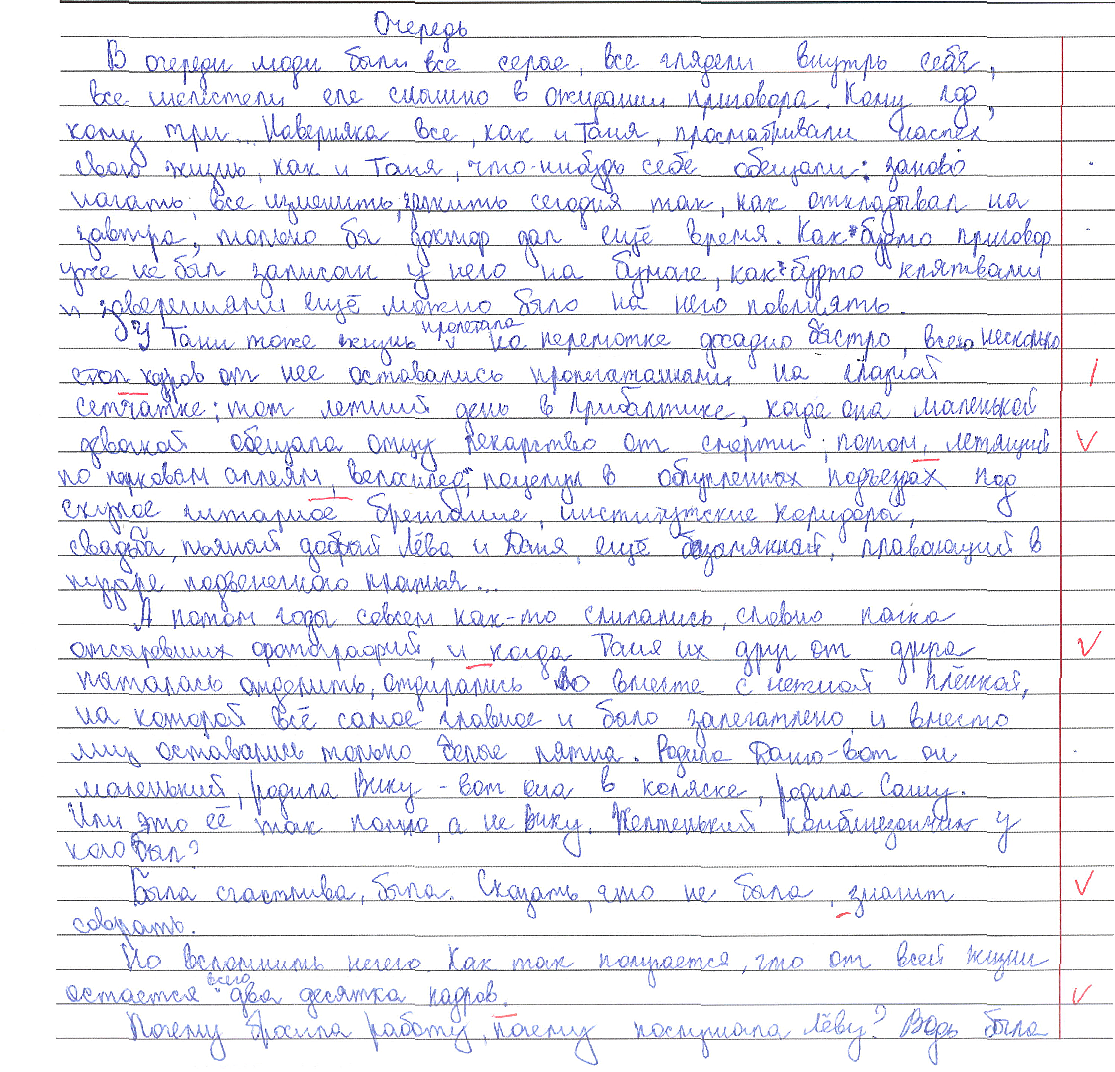

In [10]:
works[0].pages[0].body

### Trying hist approach

In [11]:
p = works[0].pages[0]
bin_img = p.bin_img
b_width, b_height = bin_img.shape
hist_data = np.sum(bin_img,axis=1,keepdims=True).reshape((1,b_width))[0]
hist_data.shape

(1072,)

Text(0.5, 1.0, 'Histogram')

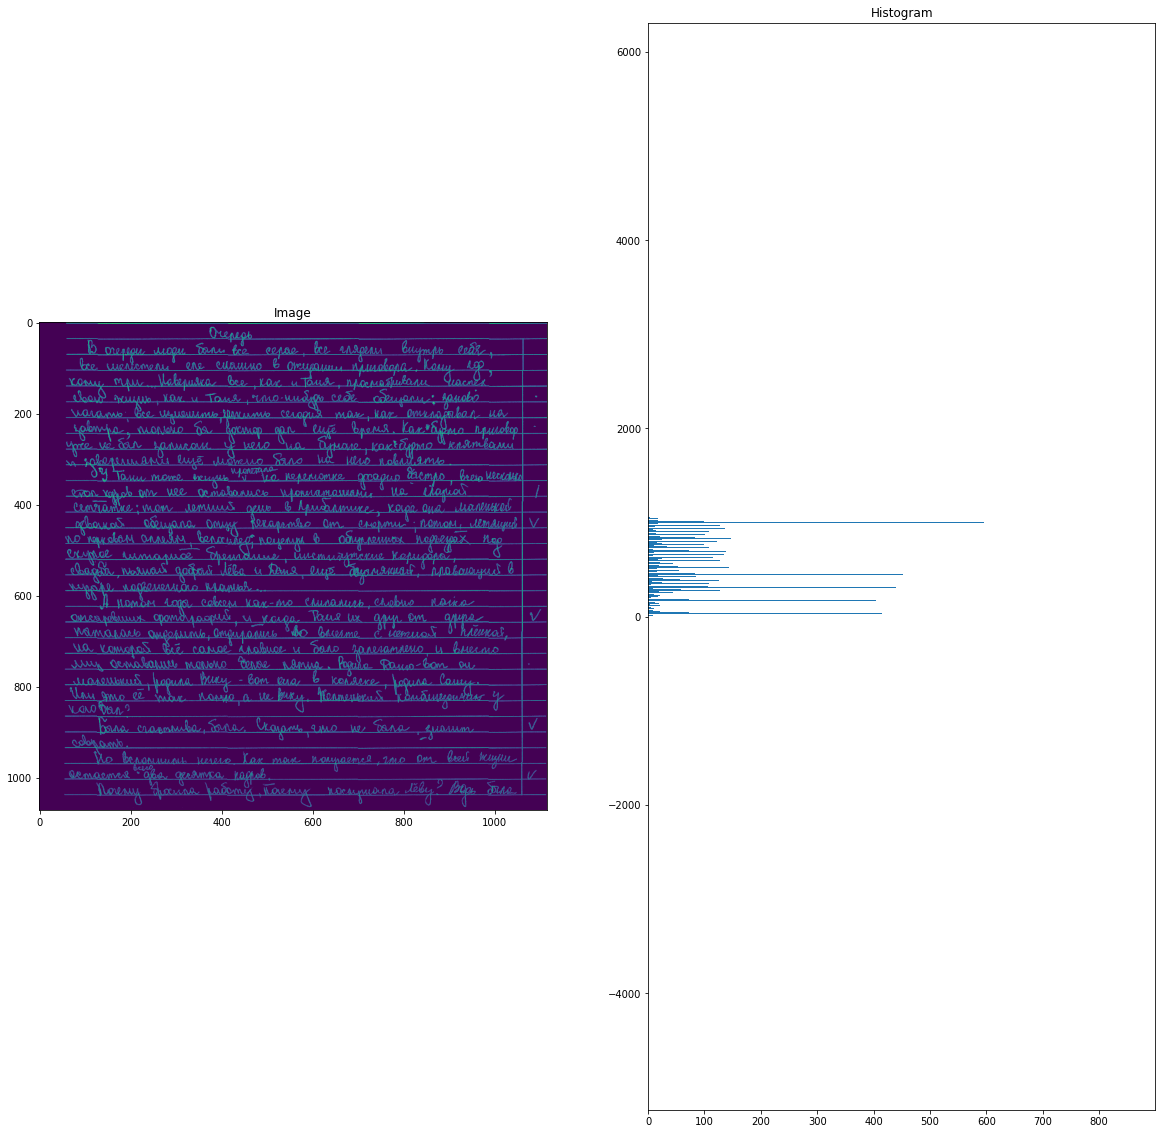

In [12]:
fig, axis = plt.subplots(1, 2)

fig.set(figheight=20, figwidth=20)

axis[0].imshow(bin_img) 
axis[0].set_title("Image")

axis[1].barh(range(0, hist_data.size),
             list(map(lambda x: int(x), hist_data))[::-1])
axis[1].set(aspect=0.167, adjustable='datalim')
axis[1].set_title("Histogram")

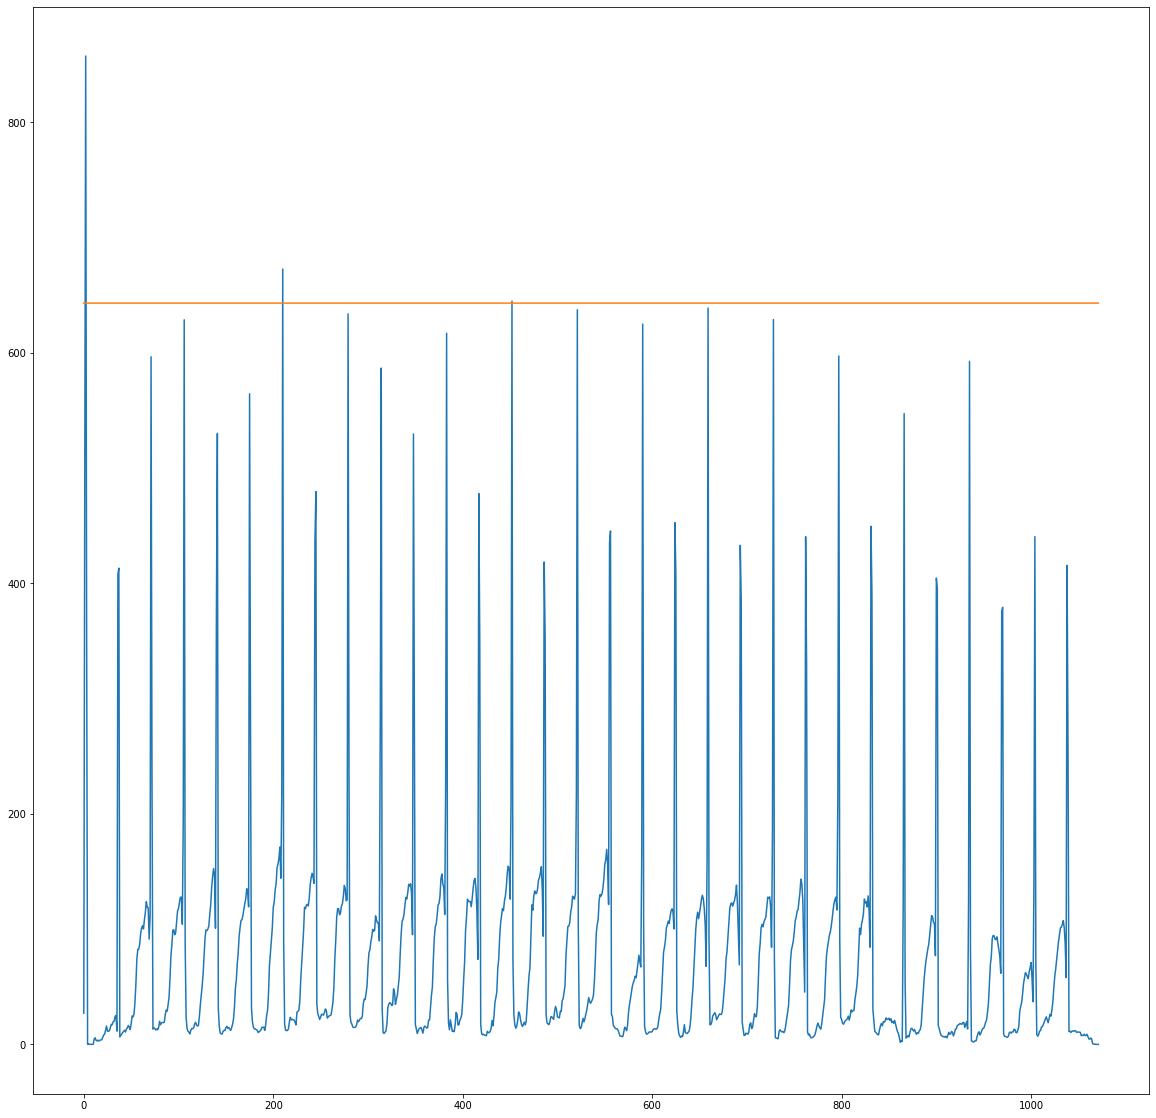

In [89]:
figure(figsize=(20, 20))
plt.plot(hist_data)
plt.plot(list(range(len(hist_data))), [max(hist_data) * 0.75] * len(hist_data))

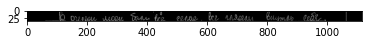

In [90]:
borders = sorted(np.argpartition(hist_data, -4)[-b_height // 30:])
tuples = [(borders[i], borders[i+1]) for i in range(len(borders)-1)]
a, b = tuples[3]
plt.imshow(bin_img[a:b], cmap='gray')

**Sadly, finding peaks and cutting accordingly is not as simple as that** <br/>
The main problem is finding *how many* peaks we should take and how do we treat lines that are not filled with text, e.g. end of section that is not on the end of a line. <br/>
We'll try another simple approach

### Find lines and cut

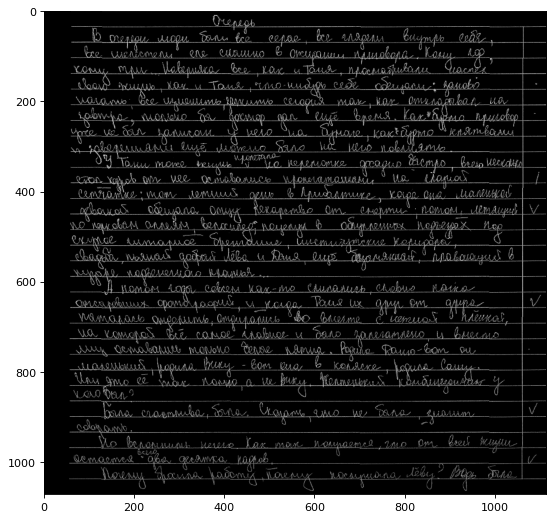

In [91]:
figure(figsize=(14, 8), dpi=80)
plt.imshow(bin_img, cmap='gray')

Получаем интервалы, в которые заключены строки

In [92]:
bounds = chop(bin_img)
bounds[10:15]

[(346, 399), (382, 432), (415, 468), (451, 502), (485, 537)]

Попробуем взять одну из строк сперва на чёрно-белой матрице, а затем и на скане работы

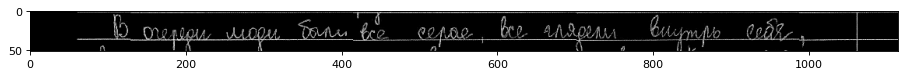

In [93]:
figure(figsize=(14, 8), dpi=80)
a, b = bounds[1]
plt.imshow(bin_img[a:b], cmap='gray')

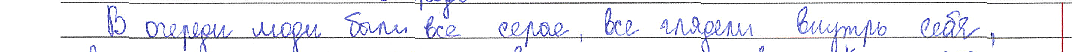

In [94]:
box = (0, a, b_width, b)
p.body.crop(box)

кайф

In [95]:
def segmentation(works):
    tqdm._instances.clear()
    for work in tqdm(works):
        for page in work.pages:
            bounds = chop(page.bin_img)
            b_height, b_width = page.bin_img.shape
            file, ext = os.path.splitext(page.path)
            page_loc_split = os.path.normpath(file).split(os.path.sep)
            chopped_loc = page_loc_split[:-3] + ['chopped', page_loc_split[-2], work.work_id, page_loc_split[-1]]
            chopped_loc = '/'.join(chopped_loc) + '/'
            os.makedirs(chopped_loc, mode=0o0777, exist_ok=True)
            for id, bound in enumerate(bounds):
                a, b = bound
                box = (0, a, b_width, b)
                line = page.body.crop(box)
                
                location = chopped_loc + str(id) + ext

                # 1900 is the experimentally derived sum of pixels in a scan of an empty line
                # However, if one of the guiding lines is not included in a cropped image, it may pass as a normal line
                # Also, sometimes parts of letters can appear on lines above or below.
                # To fight these two problems, we will also detect empty line by counting pixels in the center of it.
                tweak_colors(line)
                binary = binarize(line)
                #print(f"location: {location}, pixels: {np.sum(take_central_stripe_bin(binary))}")
                if np.sum(take_central_stripe_bin(binary)) < 50:
                    print(f"Ignored: {location}")
                    continue
                line.save(location)

                if b - a < 45 or b - a > 55:
                    print(f"Malformed text line of height {b - a} in span {a, b}: {location}")

In [96]:
segmentation(works)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Ignored: ../chopped/18956/18956_18/18956_18-1/8.png
Ignored: ../chopped/18956/18956_18/18956_18-1/9.png
Ignored: ../chopped/18956/18956_18/18956_18-1/10.png
Ignored: ../chopped/18956/18956_18/18956_18-1/11.png
Ignored: ../chopped/18956/18956_18/18956_18-1/12.png
Ignored: ../chopped/18956/18956_18/18956_18-1/13.png
Ignored: ../chopped/18956/18956_18/18956_18-1/14.png
Ignored: ../chopped/18956/18956_18/18956_18-1/15.png
Ignored: ../chopped/18956/18956_18/18956_18-1/16.png
Ignored: ../chopped/18956/18956_18/18956_18-1/17.png
Ignored: ../chopped/18956/18956_18/18956_18-1/18.png
Ignored: ../chopped/18956/18956_18/18956_18-1/19.png
Ignored: ../chopped/18956/18956_18/18956_18-1/20.png
Ignored: ../chopped/18956/18956_18/18956_18-1/21.png
Ignored: ../chopped/18956/18956_18/18956_18-1/22.png
Ignored: ../chopped/18956/18956_18/18956_18-1/23.png
Ignored: ../chopped/18956/18956_18/18956_18-1/24.png
Ignored: ../chopped/18956/18956_18/18956_18-1/25.png
Ignored: ../chopped/18956/18956_18/18956_18-1/26

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.78s/it]

Ignored: ../chopped/18956/18956_18/18956_18-1/40.png
